In [1]:
import numpy as np
import os
from lib.utils import process_sensor_data
df_dict = {}
# Define path to parent directory containing subdirectories with CSV files
parent_dir = 'sc_sensor'
# adding to the df_dict
# Loop through each subdirectory in the parent directory
# dataset_name = "crossroad"
dataset_name = "train_station"
df_dict = process_sensor_data(parent_dir, df_dict)  # only process sensor 2

In [2]:
from lib.utils import gen_data_dict, seperate_up_down
data_dict = gen_data_dict(df_dict)
# process data dict to get the upstream and downstream data
from lib.utils import seperate_up_down, generating_ood_dataset
data_dict = seperate_up_down(data_dict)

In [3]:
from torch.utils.data import DataLoader
from lib.dataloader import FlowDataset
from lib.utils import gen_data_dict, process_sensor_data, StandardScaler, sliding_win
from lib.utils import generating_ood_dataset, seperate_up_down, generating_insample_dataset, get_trainable_params_size
import dgl
import torch
import random
# set seed
torch.manual_seed(1)
#normalization
# x_scalar = StandardScaler(mean=np.concatenate([x_train, x_val]).mean(),
#                           std=np.concatenate([x_train, x_val]).std())


if dataset_name == "crossroad":
    src = np.array([0, 0, 0, 3, 3, 3, 5, 5, 5, 6, 6, 6])
    dst = np.array([4, 2, 7, 1, 4, 7, 2, 7, 1, 2, 4, 1])
    g = dgl.graph((src, dst))
    g.edata['distance'] = torch.FloatTensor([43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43]) # 50m
    
if dataset_name == "train_station":
    src = np.array([3,3,3,
                    4,4,4,
                    7,7,7,
                    22,22,22,
                    23,23,23,23,23,
                    8,8,8,8,8,
                    11, 11, 11, 11, 11,
                    14, 14, 14, 14, 14,
                    18, 18, 18,
                    17, 17, 17, 17, 17,
                    13, 13, 13,
                    21, 21, 21,
                    0, 0, 0,
                    12, 12, 12, 12, 12])
    dst = np.array([5,6,23,
                    2,6,23,
                    2,5,23,
                    2,5,6,
                    9,10,15,16,13,
                    22,10,13,15,16,
                    22,9,15,16,13,
                    22,9,10,16,13,
                    12,1,20,
                    13,15,9,10,22,
                    20,1,19,
                    19,1,12,
                    12,19,20,
                    15,16,9,10,22])
    g = dgl.graph((src, dst))
    g.edata['distance'] = torch.FloatTensor([40,40,28, # 3
                                             40,50,32, # 4
                                             40,50,32,
                                             28,32,32,
                                             24,24,41,41,35,
                                             24,50,49,54,65,
                                             24,50,65,54,49,
                                             41,54,65,50,32,
                                             25,47,50,
                                             32,50,65,54,41,
                                             25,32,25,
                                             50,47,25,
                                             32,47,47,
                                             32,32,49,49,35])


In [4]:
# data = data_dict['sc_sensor/crossroad1']
# x_train, y_train = sliding_win(data, lags=5, horizons=2)

In [5]:
if dataset_name == "crossroad":
    train_sc = ['sc_sensor/crossroad5']
    test_sc = ['sc_sensor/crossroad3']

if dataset_name == "train_station":
    train_sc = ['sc_sensor/train6']
    test_sc = ['sc_sensor/train5']

x_train, y_train, x_val, y_val, x_test, y_test = generating_ood_dataset(data_dict, train_sc, test_sc, lags=5)
num_input_timesteps = x_train.shape[1] # number of input time steps
num_nodes = x_train.shape[2] # number of ancestor nodes, minus the down stream node
x_scalar = StandardScaler(mean=np.concatenate([x_train, x_val]).mean(),
                          std=np.concatenate([x_train, x_val]).std())


In [6]:
# from Diffusion_Network import Diffusion_Model
# from Diffusion_Network2 import Diffusion_Model
from Diffusion_Network3 import Diffusion_Model
from Diffusion_Network_UQ import Diffusion_Model_UQ
model = Diffusion_Model_UQ(num_edges=len(src), num_timesteps_input=num_input_timesteps, graph=g, scalar=None)
# model = Diffusion_Model(num_edges=len(src), num_timesteps_input=num_input_timesteps, graph=g, scalar=None)
if dataset_name == "crossroad":
    # model.load_state_dict(torch.load("./checkpoint/diffusion/diffusion_model_network3_cross.pth"))
    model.load_state_dict(torch.load("./checkpoint/diffusion/diffusion_uq_cross.pth"))
if dataset_name == "train_station":
    # model.load_state_dict(torch.load("./checkpoint/diffusion/diffusion_model_network3.pth"))
    model.load_state_dict(torch.load("./checkpoint/diffusion/diffusion_uq.pth"))

In [7]:
# x = torch.cat(x_train, x_val, )
with torch.no_grad():
    x_up = torch.FloatTensor(x_test[..., src].transpose(2, 0, 1)) # [num of src, batch_size, num_timesteps_input], num of src = num of dst = num of edges
    x_down = torch.FloatTensor(x_test[..., dst].transpose(2, 0, 1)) # [num of dst, batch_size, num_timesteps_input]
    v = model.velocity_model(x_up, x_down).numpy()
    flow = torch.sum(x_up, dim=2).numpy()
    total_flow = torch.sum(torch.cat([x_up, x_down], dim=-1), dim=-1).numpy()

In [8]:
#netowrk2
g.ndata['feature'] = torch.FloatTensor(x_test.transpose(2, 0, 1))
pred = model.inference(g.ndata['feature'][src], g.ndata['feature'][dst])

In [9]:
#network
g.ndata['feature'] = torch.FloatTensor(x_test.transpose(2, 0, 1))
g.ndata['label'] = torch.FloatTensor(y_test.transpose(2, 0, 1))
z = model.transition_probability(g.ndata['feature'])
g.ndata['embedding'] = z   # for attention
g.apply_edges(model.transition_probability.edge_attention)

In [10]:
# generate matrix with the element is e
with torch.no_grad():
    num_edges = len(src)
    sample_size = x_test.shape[0]
    atten_mat = torch.zeros((num_nodes, num_nodes, sample_size))
    for i in range(num_edges):
        atten_mat[src[i], dst[i], :] = g.edata['e'][i, :]
    atten_mat = atten_mat.numpy()

In [11]:
# generate matrix with the element is e
np.around(atten_mat[..., 50], 3)

array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.462, 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.38 , 0.158, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.268, 0.36 , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.371],
       [0.   , 0.   , 0.492, 0.   , 0.   , 0.   , 0.194, 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.314],
       [0.   , 0.   , 0.   , 0.   ,

In [11]:
np.around(atten_mat[..., 50], 3)

array([[0.   , 0.   , 0.34 , 0.   , 0.319, 0.   , 0.   , 0.341],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.201, 0.   , 0.   , 0.204, 0.   , 0.   , 0.595],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.317, 0.341, 0.   , 0.   , 0.   , 0.   , 0.342],
       [0.   , 0.22 , 0.558, 0.   , 0.222, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]],
      dtype=float32)

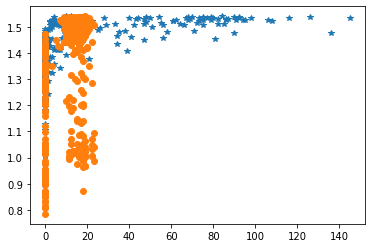

In [12]:
import matplotlib.pyplot as plt
edge_id = 3
plt.plot(flow[edge_id, :], v[:, edge_id], '*')
plt.plot(flow[0, :], v[:, 0], 'o')

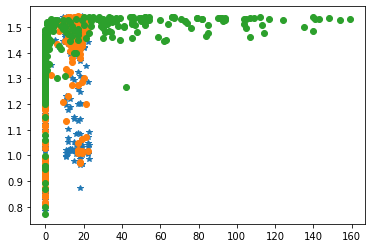

In [13]:
plt.plot(flow[0, :], v[:, 0], '*')
plt.plot(flow[1, :], v[:, 1], 'o')
plt.plot(flow[6, :], v[:, 6], 'o')

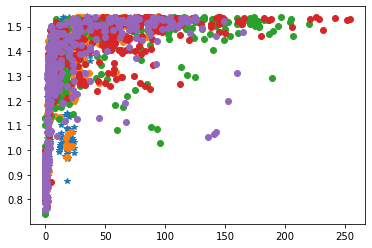

In [14]:
plt.plot(total_flow[0, :], v[:, 0], '*')
plt.plot(total_flow[1, :], v[:, 1], 'o')
plt.plot(total_flow[5, :], v[:, 5], 'o')    
plt.plot(total_flow[6, :], v[:, 6], 'o')
plt.plot(total_flow[7, :], v[:, 7], 'o')
# plt.plot(total_flow[20, :], v[:, 20], 'o')

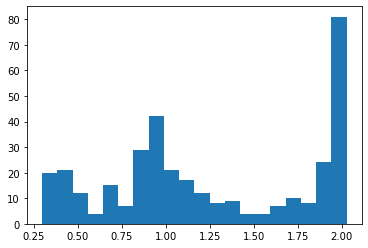

In [40]:
# distribution plot of the velocity
plt.hist(v[:, 0], bins=20)
plt.show()

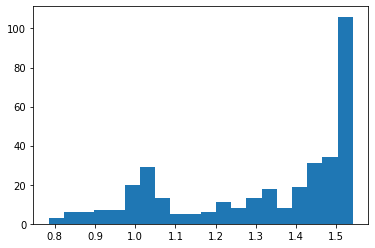

In [15]:
plt.hist(v[:, 0], bins=20)
plt.show()

In [16]:
model.alpha

Parameter containing:
tensor([[ 1.5969e-01],
        [ 7.3347e-02],
        [ 3.7181e-02],
        [ 5.8344e-02],
        [ 1.3771e-01],
        [ 2.6175e-02],
        [ 3.0470e-01],
        [ 3.0973e-01],
        [ 2.4233e-02],
        [ 3.6969e-02],
        [ 7.8801e-02],
        [ 6.6820e-02],
        [ 1.0501e-01],
        [ 1.9546e-02],
        [ 8.3492e-02],
        [ 4.6189e-02],
        [ 1.8414e-02],
        [ 1.0904e-03],
        [ 5.8871e-02],
        [ 1.4692e-02],
        [ 7.3217e-02],
        [ 1.2285e-02],
        [ 4.3882e-02],
        [ 2.9993e-02],
        [ 5.3522e-02],
        [ 5.0850e-01],
        [ 3.8449e-03],
        [ 4.6836e-02],
        [ 3.8807e-01],
        [ 1.0727e-04],
        [ 1.6067e-02],
        [ 8.0624e-03],
        [ 1.4440e-03],
        [ 1.1252e-02],
        [ 2.5775e-01],
        [ 2.9756e-02],
        [ 1.1595e-01],
        [ 1.7367e-02],
        [-1.5023e-03],
        [ 2.5611e-03],
        [ 6.8201e-02],
        [ 2.3291e-02],
        [ 1.

## Visualization

In [25]:
from lib.metric import masked_rmse_np, masked_mae_np, rho_risk, weighted_average_loss
# data = data_dict['sc_sensor/crossroad3']
data = data_dict['sc_sensor/train7']
x_test, y_test = sliding_win(data, lags=5, horizons=2)
# x_test2, y_test2 = sliding_win(data2, lags=5, horizons=2)
g.ndata['feature'] = torch.FloatTensor(x_test.transpose(2, 0, 1))
g.ndata['label'] = torch.FloatTensor(y_test.transpose(2, 0, 1))

Text(0.5, 1.0, 'RMSE: 5.2221150398254395')

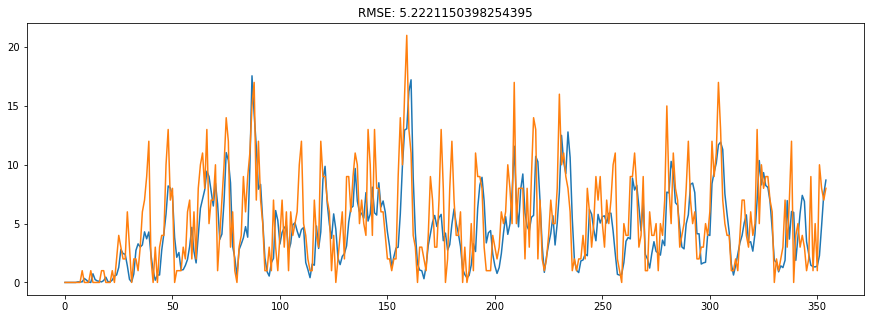

In [31]:
import matplotlib.pyplot as plt
id = 1
# model = Diffusion_Model(num_edges=len(src), num_timesteps_input=x_train.shape[1], graph=g, scalar=x_scalar)
# model.load_state_dict(torch.load("./checkpoint/diffusion/diffusion_model_network3.pth"))
# model.load_state_dict(torch.load("./checkpoint/diffusion/diffusion_model_network3_cross.pth"))
# model.load_state_dict(torch.load("./checkpoint/diffusion/diffusion_uq.pth"))
up = torch.FloatTensor(x_test.transpose(2, 0, 1))[src]
down = torch.FloatTensor(x_test.transpose(2, 0, 1))[dst]
with torch.no_grad():
    pred = model.inference(up, down).numpy()
    v = model.velocity_model(g.ndata['feature'][5].unsqueeze(0), g.ndata['feature'][id].unsqueeze(0)).numpy()
# plot prediction and ground truth

# label = g.ndata['label'][:,:, 0].numpy()
label = y_test.transpose(2, 0, 1)
# label2 = y_test2.transpose(2, 0, 1)
x = np.arange(0, label.shape[1])

#adjust figure size
plt.figure(figsize=(15, 5))
plt.plot(x, pred[id, :])
plt.plot(x, label[id, :])
# plt.plot(x, label2[id, :])
# plt.plot(x, label[3, :])
# plt.plot(x, label[0, :])
# plt.plot(x, label[6, :])
# plt.plot(x, v)
rmse = masked_rmse_np(pred[id, :], label[id, :])
# rt = np.sum(rho_risk(pred[id, :], label[id, :], timespan=2, rho=0.9))
# wt = weighted_average_loss(pred.T, label.T, rho=0.9, timespan=2)
plt.title(f'RMSE: {rmse}')

Text(0.5, 1.0, 'RMSE: 5.225503921508789')

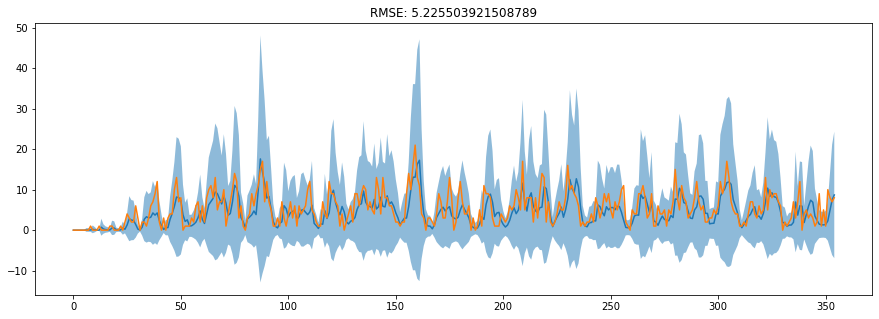

In [34]:
up = torch.FloatTensor(x_test.transpose(2, 0, 1))[src]
down = torch.FloatTensor(x_test.transpose(2, 0, 1))[dst]
with torch.no_grad():
    pred = model.inference(up, down).numpy()
    v = model.velocity_model(g.ndata['feature'][5].unsqueeze(0), g.ndata['feature'][id].unsqueeze(0)).numpy()
# plot prediction and ground truth

# label = g.ndata['label'][:,:, 0].numpy()
label = y_test.transpose(2, 0, 1)
# label2 = y_test2.transpose(2, 0, 1)
x = np.arange(0, label.shape[1])

#adjust figure size
plt.figure(figsize=(15, 5))
plt.plot(x, pred[id, :])
plt.plot(x, label[id, :])
sigma = g.ndata['sigma'].numpy()
sigma = np.sqrt(pred + pred ** 2 * sigma)
# plot prediction interval
plt.fill_between(x, pred[id, :] - 2 * sigma[id, :], pred[id, :] + 2 * sigma[id, :], alpha=0.5)
# plt.plot(x, v)
rmse = masked_rmse_np(pred[id, :], label[id, :])
# rt = np.sum(rho_risk(pred[id, :], label[id, :], timespan=2, rho=0.9))
# wt = weighted_average_loss(pred.T, label.T, rho=0.9, timespan=2)
plt.title(f'RMSE: {rmse}')

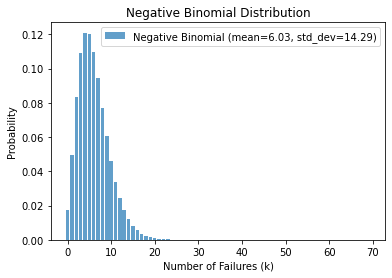

In [28]:
from scipy.stats import nbinom
ts = 250
# id = 2
# Set mean and standard deviation
mean = pred[id, ts]
std_dev = np.sqrt(pred[id, ts] + pred[id, ts]**2 * sigma[id, ts])

# Calculate shape parameter (k)
# k = (mean ** 2) / (std_dev ** 2)

# Generate x values for the plot
# x_values = np.arange(0, 2 * mean)
x_values = np.arange(0, 70)
# Calculate the probability mass function (PMF) for each x value
pmf_values = nbinom.pmf(x_values, n=sigma[id, ts], p=sigma[id, ts]/(sigma[id, ts] + mean))
# Plot the negative binomial distribution
plt.bar(x_values, pmf_values, label=f'Negative Binomial (mean={mean:.2f}, std_dev={std_dev:.2f})', alpha=0.7)
plt.title('Negative Binomial Distribution')
plt.xlabel('Number of Failures (k)')
plt.ylabel('Probability')
plt.legend()
plt.show()


In [45]:
g.ndata['feature'] = torch.FloatTensor(x_test.transpose(2, 0, 1))
g.ndata['label'] = torch.FloatTensor(y_test.transpose(2, 0, 1))
z = model.transition_probability(g.ndata['feature'])
g.ndata['embedding'] = z   # for attention
g.apply_edges(model.transition_probability.edge_attention)

In [46]:
with torch.no_grad():
    num_edges = len(src)
    sample_size = x_test.shape[0]
    atten_mat = torch.zeros((num_nodes, num_nodes, sample_size))
    for i in range(num_edges):
        atten_mat[src[i], dst[i], :] = g.edata['e'][i, :]
    atten_mat = atten_mat.numpy()

In [47]:
atten_mat[:, :, 270]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00290485, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.69258106,
        0.30451414, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.   

In [29]:
# xgboost
import xgboost as xgb
loaded_model = xgb.Booster()
loaded_model.load_model('./checkpoint/xgboost/xgboost_train_station.model')
# loaded_model.load_model('./checkpoint/xgboost/xgboost_cross.model')

Text(0.5, 1.0, 'RMSE: 5.116935729980469')

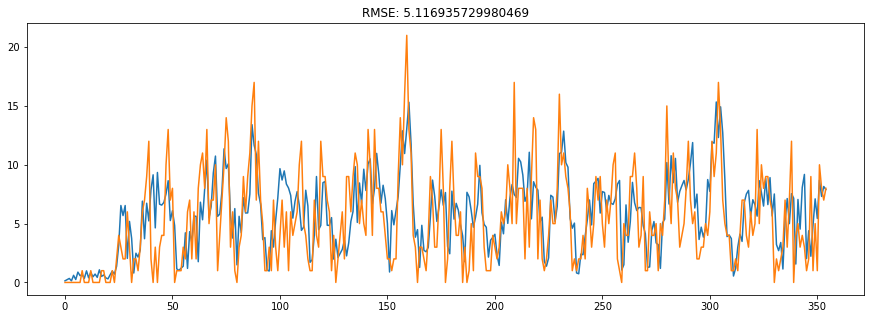

In [33]:
pred_horizon = 1
x = x_test.reshape([-1, num_input_timesteps * num_nodes])
# y = y_test.reshape([-1, pred_horizon * num_nodes])
# y_test = y_test.reshape([-1, num_input_timesteps * num_nodes])
pred = loaded_model.predict(xgb.DMatrix(x))
pred = pred.T
x2 = np.arange(0, label.shape[1])
plt.figure(figsize=(15, 5))
plt.plot(x2, pred[id, :])
plt.plot(x2, label[id, :])
# plt.plot(x2, label[0, :])
rmse = masked_rmse_np(pred[id, :], label[id, :])
# rt = np.sum(rho_risk(pred[id, :], label[id, :], timespan=2, rho=0.9))
plt.title(f'RMSE: {rmse}')

Text(0.5, 1.0, 'RMSE: 4.833185195922852')

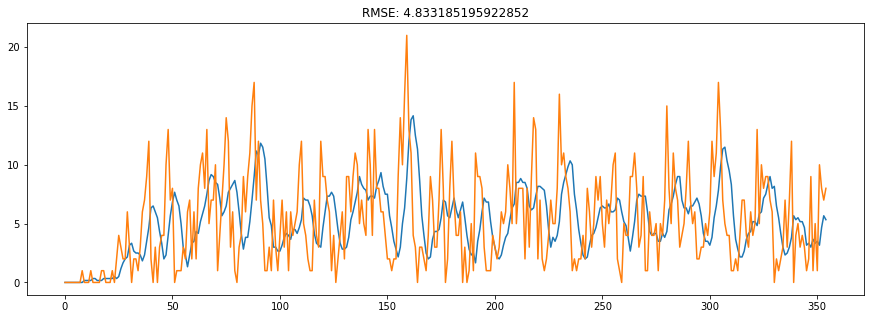

In [32]:
# MA
from baselines.MA import Moving_Average
ma = Moving_Average()
pred = ma.inference(g.ndata['feature']).numpy()
# pred = pred.T
x = np.arange(0, label.shape[1])
plt.figure(figsize=(15, 5))
plt.plot(x, pred[id, :])
plt.plot(x, label[id, :])
rmse = masked_rmse_np(pred[id, :], label[id, :])
# rt = np.sum(rho_risk(pred[id, :], label[id, :], timespan=2, rho=0.9))
plt.title(f'RMSE: {rmse}')

In [36]:
import torch

# Example tensor
tensor = torch.tensor([[1, 0, 3], [0, 5, 0], [7, 8, 0]])

# Find the indices of zero elements
zero_indices = (tensor == 0).nonzero(as_tuple=True)

print("Indices of zero elements:")
print(zero_indices)

Indices of zero elements:
(tensor([0, 1, 1, 2]), tensor([1, 0, 2, 2]))
